In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import shap

In [2]:
# Load datasets from Kaggle
tech_survey = pd.read_csv('/kaggle/input/mental-health-survey/Mental Health Dataset.csv')
depression_anxiety = pd.read_csv('/kaggle/input/mental-health-survey/depression_anxiety_data.csv')
who_data = pd.read_csv('/kaggle/input/mental-health-survey/survey.csv')

# Combine datasets if necessary
combined_data = pd.concat([tech_survey, depression_anxiety, who_data], axis=0, ignore_index=True)

In [3]:
# Inspect each dataset
print("Tech Survey Columns:", tech_survey.columns)
print("Depression/Anxiety Columns:", depression_anxiety.columns)
print("WHO Data Columns:", who_data.columns)

Tech Survey Columns: Index(['Timestamp', 'Gender', 'Country', 'Occupation', 'self_employed',
       'family_history', 'treatment', 'Days_Indoors', 'Growing_Stress',
       'Changes_Habits', 'Mental_Health_History', 'Mood_Swings',
       'Coping_Struggles', 'Work_Interest', 'Social_Weakness',
       'mental_health_interview', 'care_options'],
      dtype='object')
Depression/Anxiety Columns: Index(['id', 'school_year', 'age', 'gender', 'bmi', 'who_bmi', 'phq_score',
       'depression_severity', 'depressiveness', 'suicidal',
       'depression_diagnosis', 'depression_treatment', 'gad_score',
       'anxiety_severity', 'anxiousness', 'anxiety_diagnosis',
       'anxiety_treatment', 'epworth_score', 'sleepiness'],
      dtype='object')
WHO Data Columns: Index(['Timestamp', 'Age', 'Gender', 'Country', 'state', 'self_employed',
       'family_history', 'treatment', 'work_interfere', 'no_employees',
       'remote_work', 'tech_company', 'benefits', 'care_options',
       'wellness_program', 

In [4]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Load datasets
tech_survey = pd.read_csv('/kaggle/input/mental-health-survey/Mental Health Dataset.csv')
depression_anxiety = pd.read_csv('/kaggle/input/mental-health-survey/depression_anxiety_data.csv')
who_data = pd.read_csv('/kaggle/input/mental-health-survey/survey.csv')

# Tech Survey: Create 'symptoms' and 'condition' columns
tech_survey['symptoms'] = (
    tech_survey['Growing_Stress'].astype(str) + " " +
    tech_survey['Changes_Habits'].astype(str) + " " +
    tech_survey['Mood_Swings'].astype(str) + " " +
    tech_survey['Coping_Struggles'].astype(str)
)
tech_survey['condition'] = tech_survey['treatment'].map({1: 'Treated', 0: 'Untreated'})
tech_survey = tech_survey[['symptoms', 'condition']]

# Depression/Anxiety: Create 'symptoms' and 'condition' columns
depression_anxiety['symptoms'] = (
    "PHQ Score: " + depression_anxiety['phq_score'].astype(str) + ", " +
    "GAD Score: " + depression_anxiety['gad_score'].astype(str) + ", " +
    "Epworth Score: " + depression_anxiety['epworth_score'].astype(str)
)
depression_anxiety['condition'] = (
    depression_anxiety['depression_diagnosis'].astype(str) + " " +
    depression_anxiety['anxiety_diagnosis'].astype(str)
)
depression_anxiety = depression_anxiety[['symptoms', 'condition']]

# WHO Data: Create 'symptoms' and 'condition' columns
who_data['symptoms'] = (
    who_data['work_interfere'].astype(str) + " " +
    who_data['mental_health_consequence'].astype(str) + " " +
    who_data['phys_health_consequence'].astype(str)
)
who_data['condition'] = who_data['treatment'].map({1: 'Treated', 0: 'Untreated'})
who_data = who_data[['symptoms', 'condition']]

# Combine datasets
combined_data = pd.concat([tech_survey, depression_anxiety, who_data], axis=0, ignore_index=True)

# Handle missing values
combined_data = combined_data.dropna(subset=['symptoms', 'condition'])

# Normalize text data (e.g., symptoms column)
tfidf = TfidfVectorizer(max_features=100)
symptom_vectors = tfidf.fit_transform(combined_data['symptoms'])

# Encode labels (mental health conditions)
label_encoder = LabelEncoder()
combined_data['condition'] = label_encoder.fit_transform(combined_data['condition'])

# Verify final data
print("Combined Data Shape:", combined_data.shape)
print("Sample Data:")
print(combined_data.head())

Combined Data Shape: (783, 2)
Sample Data:
                                                 symptoms  condition
292364    PHQ Score: 9, GAD Score: 11, Epworth Score: 7.0          0
292365    PHQ Score: 8, GAD Score: 5, Epworth Score: 14.0          0
292366     PHQ Score: 8, GAD Score: 6, Epworth Score: 6.0          0
292367  PHQ Score: 19, GAD Score: 15, Epworth Score: 11.0          0
292368    PHQ Score: 6, GAD Score: 14, Epworth Score: 3.0          0


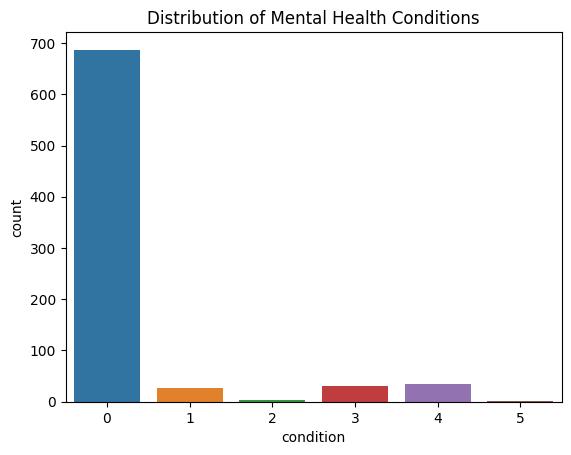

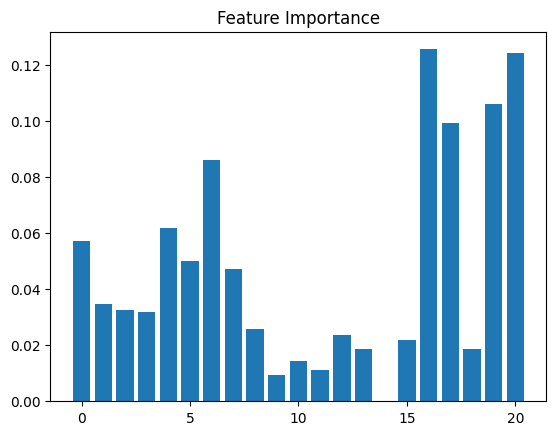

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of conditions
sns.countplot(x='condition', data=combined_data)
plt.title("Distribution of Mental Health Conditions")
plt.show()

# Feature importance visualization (using Random Forest)
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(symptom_vectors, combined_data['condition'])
feature_importances = rf.feature_importances_

plt.bar(range(len(feature_importances)), feature_importances)
plt.title("Feature Importance")
plt.show()

In [9]:
from sklearn.feature_selection import SelectKBest, chi2

# Check the number of features
print("Number of Features in symptom_vectors:", symptom_vectors.shape[1])

# Perform feature selection with k <= n_features
k = min(50, symptom_vectors.shape[1])  # Ensure k does not exceed the number of features
selector = SelectKBest(chi2, k=k)
X_selected = selector.fit_transform(symptom_vectors, combined_data['condition'])

print("Selected Features Shape:", X_selected.shape)

Number of Features in symptom_vectors: 21
Selected Features Shape: (783, 21)


In [10]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = symptom_vectors  # TF-IDF vectors
y = combined_data['condition']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Set Size:", X_train.shape)
print("Testing Set Size:", X_test.shape)

Training Set Size: (626, 21)
Testing Set Size: (157, 21)


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Train and evaluate Random Forest
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, y_pred_rf, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred_rf, average='weighted'))

# ROC-AUC Score
try:
    print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test), multi_class='ovr'))
except ValueError as e:
    print(f"Error calculating ROC-AUC: {e}")

Random Forest Evaluation:
Accuracy: 0.8853503184713376
Precision: 0.8163619819670774
Recall: 0.8853503184713376
F1-Score: 0.8494577379927699
Error calculating ROC-AUC: Number of classes in y_true not equal to the number of columns in 'y_score'


In [12]:
print("Unique classes in y_train:", np.unique(y_train))
print("Unique classes in y_test:", np.unique(y_test))

Unique classes in y_train: [0 1 2 3 4 5]
Unique classes in y_test: [0 1 2 3 4]


In [13]:
import numpy as np

# Count occurrences of each class
class_counts = np.bincount(y)
print("Class counts:", class_counts)

# Identify classes with fewer than 2 samples
insufficient_classes = np.where(class_counts < 2)[0]
print("Classes with insufficient samples:", insufficient_classes)

Class counts: [687  26   3  31  35   1]
Classes with insufficient samples: [5]


In [14]:
# Filter out rows with insufficient classes
valid_classes = np.where(class_counts >= 2)[0]
mask = np.isin(y, valid_classes)
X_filtered = X[mask]
y_filtered = y[mask]

# Verify the filtered dataset
print("Filtered Class counts:", np.bincount(y_filtered))

Filtered Class counts: [687  26   3  31  35]


In [15]:
from sklearn.model_selection import train_test_split

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered
)

# Verify unique classes
print("Unique classes in y_train:", np.unique(y_train))
print("Unique classes in y_test:", np.unique(y_test))

Unique classes in y_train: [0 1 2 3 4]
Unique classes in y_test: [0 1 2 3 4]


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf.predict(X_test)

# Evaluate the model
print("Random Forest Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, y_pred_rf, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred_rf, average='weighted'))

# Check ROC-AUC
try:
    print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test), multi_class='ovr'))
except ValueError as e:
    print(f"Error calculating ROC-AUC: {e}")

Random Forest Evaluation:
Accuracy: 0.8535031847133758
Precision: 0.774891049279249
Recall: 0.8535031847133758
F1-Score: 0.8122995826927301
ROC-AUC: 0.45551845621051673


In [17]:
import numpy as np

# Count occurrences of each class
class_counts = np.bincount(y_filtered)
print("Class counts:", class_counts)

# Identify classes with fewer than 6 samples
problematic_classes = np.where(class_counts < 6)[0]
print("Problematic classes (fewer than 6 samples):", problematic_classes)

Class counts: [687  26   3  31  35]
Problematic classes (fewer than 6 samples): [2]


In [18]:
from imblearn.over_sampling import SMOTE

# Find the minimum number of samples in any class
min_samples = np.min(class_counts[class_counts > 0])
k_neighbors = min(min_samples - 1, 5)  # Ensure k_neighbors is at least 1 and <= 5

# Apply SMOTE with adjusted k_neighbors
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_resampled, y_resampled = smote.fit_resample(X_filtered, y_filtered)

# Verify resampled class distribution
print("Resampled Class counts:", np.bincount(y_resampled))

Resampled Class counts: [687 687 687 687 687]


In [19]:
# Define a threshold for minimum samples per class
min_samples_threshold = 6

# Filter out classes with insufficient samples
valid_classes = np.where(class_counts >= min_samples_threshold)[0]
mask = np.isin(y_filtered, valid_classes)
X_filtered = X_filtered[mask]
y_filtered = y_filtered[mask]

# Verify filtered class distribution
print("Filtered Class counts:", np.bincount(y_filtered))

Filtered Class counts: [687  26   0  31  35]


In [20]:
from sklearn.model_selection import train_test_split

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Verify unique classes
print("Unique classes in y_train:", np.unique(y_train))
print("Unique classes in y_test:", np.unique(y_test))


Unique classes in y_train: [0 1 2 3 4]
Unique classes in y_test: [0 1 2 3 4]


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)

# Evaluate the model
print("Random Forest Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, y_pred_rf, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred_rf, average='weighted'))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf, multi_class='ovr'))

Random Forest Evaluation:
Accuracy: 0.7030567685589519
Precision: 0.7878265531934603
Recall: 0.7030567685589519
F1-Score: 0.7081374567256822
ROC-AUC: 0.9101080773554358
